In [2]:
import os
import sys
import joblib
import pickle

from functools import partial

from concurrent.futures import ProcessPoolExecutor

import networkx as nx

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from graph_based_intrusion_detection.utils import constants
from graph_based_intrusion_detection.packet_processing.processing_functions import process_packets, \
    multi_process_packets
from graph_based_intrusion_detection.packet_processing.packet_inspection import update_port_list
from graph_based_intrusion_detection.packet_processing.graph_processing import update_layer_3_graph, \
    update_layer_2_graph

from graph_based_intrusion_detection.utils.state_merging import merge_graph, merge_by_key, merge_states

from graph_based_intrusion_detection.graph_processing.data_extraction import get_info_for_node, extract_connections, \
    create_dataset_for_node

# constants
devices_root = os.path.abspath('../../../')
time_field = 'geninfo/timestamp'
timedelta_field = "timedelta"

In [4]:
# read merged dataset
row_limit = None
idle_dataset_path = os.path.join(devices_root, 'idle_merged.pickle')
activity_dataset_path = os.path.join(devices_root, 'activity_merged.pickle')
attack_dataset_path = os.path.join(devices_root, 'attack_merged.pickle')

idle_dataset = pd.read_pickle(idle_dataset_path)
activity_dataset = pd.read_pickle(activity_dataset_path)
attack_dataset = pd.read_pickle(attack_dataset_path)

merged_dataset_full = pd.concat([idle_dataset, activity_dataset, attack_dataset])
merged_dataset = merged_dataset_full

print(f"Loaded merged dataset with {len(merged_dataset)} packets")
list(sorted(merged_dataset.columns))

Loaded merged dataset with 3194477 packets


['Activity',
 'Attack',
 'Farbeändern',
 'Helligkeitssteuern',
 'Party',
 'Themen Auswahl',
 'Timer Ein/Aus',
 'Weiß/gelb',
 'Zeitschalter',
 'arp/arp.hw.size',
 'arp/arp.hw.type',
 'arp/arp.opcode',
 'arp/arp.proto.size',
 'arp/arp.proto.type',
 'eth/eth.dst',
 'eth/eth.dst/eth.dst.ig',
 'eth/eth.dst/eth.dst.oui',
 'eth/eth.dst/eth.lg',
 'eth/eth.src',
 'eth/eth.src/eth.ig',
 'eth/eth.src/eth.lg',
 'eth/eth.src/eth.src.oui',
 'eth/eth.type',
 'frame/frame.encap_type',
 'frame/frame.len',
 'frame/frame.marked',
 'frame/frame.number',
 'frame/frame.offset_shift',
 'frame/frame.time_delta',
 'frame/frame.time_relative',
 'geninfo/timestamp',
 'icmp/data/data.len',
 'icmp/icmp.checksum.status',
 'icmp/icmp.code',
 'icmp/icmp.ident',
 'icmp/icmp.resp_in',
 'icmp/icmp.resp_to',
 'icmp/icmp.seq',
 'icmp/icmp.seq_le',
 'icmp/icmp.type',
 'igmp/igmp.checksum.status',
 'igmp/igmp.maddr',
 'igmp/igmp.max_resp',
 'igmp/igmp.type',
 'illuminance_level',
 'ip/<>/ip.options.routeralert/ip.opt.ra',
 

In [4]:
merged_dataset.head()

tcp/tcp.flags/tcp.flags.reset  arp/arp.proto.size  \
0                          False                 NaN   
1                          False                 NaN   
2                          False                 NaN   
3                          False                 NaN   
4                          False                 NaN   

   tcp/tcp.options/tcp.options.nop  tcp/tcp.checksum.status  \
0                              1.0                      2.0   
1                              1.0                      2.0   
2                              NaN                      2.0   
3                              NaN                      2.0   
4                              NaN                      2.0   

   udp/udp.checksum.status  tcp/tcp.nxtseq  \
0                      NaN             1.0   
1                      NaN             1.0   
2                      NaN            70.0   
3                      NaN            70.0   
4                      NaN            70.0   

   tcp/tcp.options/tcp.options.mss/tcp.options.mss_val  tcp/tcp.hdr_len  \
0                                                NaN               32.0   
1                                                NaN               32.0   
2                                                NaN               20.0   
3                                                NaN               20.0   
4                                                NaN               20.0   

   tcp/tcp.stream       ip/ip.dst  ...  Farbeändern  Helligkeitssteuern  \
0             0.0   192.168.1.201  ...          NaN                 NaN   
1             0.0   54.155.16.139  ...          NaN                 NaN   
2             1.0  76.223.105.139  ...          NaN                 NaN   
3             1.0   192.168.1.178  ...          NaN                 NaN   
4             1.0  76.223.105.139  ...          NaN                 NaN   

   Weiß/gelb Themen Auswahl  Party  Zeitschalter  Timer Ein/Aus  \
0        NaN            NaN    NaN           NaN            NaN   
1        NaN            NaN    NaN           NaN            NaN   
2        NaN            NaN    NaN           NaN            NaN   
3        NaN            NaN    NaN           NaN            NaN   
4        NaN            NaN    NaN           NaN            NaN   

   presence_absence  illuminance_level  Attack  
0               NaN                NaN     NaN  
1               NaN                NaN     NaN  
2               NaN                NaN     NaN  
3               NaN                NaN     NaN  
4               NaN                NaN     NaN  

[5 rows x 101 columns]

In [5]:
per_packet_fields = [
    {
        "name": "total_packet_count",
        "min_layer": 2,
        "base_value_function": lambda _: 1,
        "update_function": lambda x, _: x + 1
    },
    {
        "name": "total_bytes",
        "min_layer": 2,
        "base_value_function": lambda packet: packet["frame/frame.len"],
        "update_function": lambda x, packet: x + packet["frame/frame.len"]
    },
    {
        "name": "src_ports",
        "min_layer": 4,
        "base_value_function": lambda packet: update_port_list(packet, [], "tcp/tcp.srcport"),
        "update_function": lambda x, packet: update_port_list(packet, x, "tcp/tcp.srcport"),
    },
    {
        "name": "dst_ports",
        "min_layer": 4,
        "base_value_function": lambda packet: update_port_list(packet, [], "tcp/tcp.dstport"),
        "update_function": lambda x, packet: update_port_list(packet, x, "tcp/tcp.dstport"),
    },
]

per_second_fields = [
    {
        "name": "packets_per_second",
        "min_layer": 2,
        "base_value_function": lambda _: 1,
        "update_function": lambda x, _: x + 1
    },
    {
        "name": "bytes_per_second",
        "min_layer": 2,
        "base_value_function": lambda packet: packet["frame/frame.len"],
        "update_function": lambda x, packet: x + packet["frame/frame.len"]
    },
    {
        "name": "max_tcp_segment_size",
        "min_layer": 4,
        "base_value_function": lambda packet: packet["tcp/tcp.options/tcp.options.mss/tcp.options.mss_val"],
        "update_function": lambda x, packet:
        packet["tcp/tcp.options/tcp.options.mss/tcp.options.mss_val"] if x < packet[
            "tcp/tcp.options/tcp.options.mss/tcp.options.mss_val"] else x
    },
    {
        "name": "max_tcp_header_length",
        "min_layer": 4,
        "base_value_function": lambda packet: packet["tcp/tcp.hdr_len"],
        "update_function": lambda x, packet:
        packet["tcp/tcp.hdr_len"] if x < packet["tcp/tcp.hdr_len"] else x
    },
    {
        "name": "max_frame_length",
        "min_layer": 2,
        "base_value_function": lambda packet: packet["frame/frame.len"],
        "update_function": lambda x, packet: packet["frame/frame.len"] if x < packet["frame/frame.len"] else x
    },
    {
        "name": "min_frame_length",
        "min_layer": 2,
        "base_value_function": lambda packet: packet["frame/frame.len"],
        "update_function": lambda x, packet: packet["frame/frame.len"] if x > packet["frame/frame.len"] else x
    },
    # see, if current second has activity set
    {
        "name": "activity_at_second",
        "min_layer": 1,
        "base_value_function": lambda packet: 1 if "Activity" in packet and packet["Activity"] == True else None,
        "update_function": lambda x, packet: 1 if "Activity" in packet and packet["Activity"] == True else None
    },
    # see, if current second has attack set
    {
        "name": "attack_at_second",
        "min_layer": 1,
        "base_value_function": lambda packet: 1 if "Attack" in packet and packet["Attack"] == True else None,
        "update_function": lambda x, packet: 1 if x or ("Attack" in packet and packet["Attack"] == True) else None
    }
]

processing_functions = [
    partial(update_layer_3_graph, per_packet_fields=per_packet_fields, per_second_fields=per_second_fields,
            timedelta_field=constants.TIMEDELTA_FIELD)
]

limit = 50_000
state = process_packets(merged_dataset.iloc[:limit], processing_functions, verbose=True)
# 
# layer_2_graph = state["layer_2_graph"]
# layer_3_graph = state["layer_3_graph"]

100%|██████████| 50000/50000 [00:00<00:00, 170936.26it/s]


In [6]:
state

In [7]:
def global_parameterless_processing_function(packets):
    return process_packets(packets, processing_functions, None)

# state = multi_process_packets(merged_dataset, global_parameterless_processing_function, merge_graph, 25,
#                               chunk_size=100_000)
# state


/home/alex/projects/it-security-praktikum/venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
100%|██████████| 31/31 [00:29<00:00,  1.07it/s]


In [8]:
# save state to skip processing
# state_path = os.path.join(devices_root, "state.pickle")
# with open(state_path, "wb") as f:
#     pickle.dump(state, f)

In [6]:
# load state
state_path = os.path.join(devices_root, "state.pickle")
with open(state_path, "rb") as f:
    state = pickle.load(f)

In [10]:
len(state.edges())

1860

In [11]:
# get edge data for an edge
g = state
edges = list(g.edges(data=True))
edge_data = edges[0][2]
edge_data

{'total_packet_count': 3875,
 'total_bytes': 389193.0,
 'src_ports': [443],
 'dst_ports': [49872],
 'packets_per_second': {0: 1,
  2: 2,
  20: 1,
  33: 1,
  40: 1,
  61: 1,
  64: 1,
  81: 1,
  95: 1,
  102: 1,
  122: 1,
  127: 1,
  143: 1,
  158: 1,
  163: 1,
  184: 1,
  189: 1,
  204: 1,
  220: 1,
  225: 1,
  244: 1,
  245: 1,
  266: 1,
  275: 1,
  286: 1,
  306: 1,
  307: 1,
  327: 1,
  337: 1,
  348: 1,
  368: 1,
  369: 2,
  370: 1,
  371: 2,
  391: 1,
  403: 1,
  411: 1,
  432: 1,
  434: 1,
  452: 1,
  465: 1,
  473: 1,
  485: 1,
  493: 1,
  514: 1,
  516: 1,
  534: 1,
  547: 1,
  555: 1,
  575: 1,
  578: 1,
  595: 1,
  609: 1,
  616: 1,
  636: 1,
  640: 1,
  657: 1,
  671: 1,
  677: 1,
  698: 1,
  703: 1,
  718: 1,
  727: 1,
  739: 1,
  758: 1,
  759: 1,
  780: 1,
  789: 1,
  800: 1,
  820: 1,
  821: 1,
  831: 3,
  841: 1,
  862: 1,
  863: 2,
  876: 1,
  882: 1,
  902: 2,
  903: 1,
  923: 1,
  933: 1,
  944: 1,
  964: 1,
  965: 1,
  968: 1,
  987: 1,
  999: 1,
  1007: 1,
  1028: 1

In [11]:
# add packets to queue
# for index, packet in merged_dataset.iloc[:100_000].iterrows():
#     packet_queue.put(packet)

In [12]:
# end threads
# for worker_thread in workers:
#     worker_thread.join()
# 
# merger_thread.join()

In [12]:

# run for all connections


g = state
per_second_attributes = [x["name"] for x in per_second_fields]
nodes = list(g.nodes())
edges_per_node = [list(g.in_edges(node, data=True)) + list(g.out_edges(node, data=True)) for node in nodes]
per_connection_attributes = [x["name"] for x in per_packet_fields]

# create sub-graphs containing only the node as well as all connected nodes, reduces memory usage
sub_graphs = [nx.DiGraph(nx.subgraph(g, [node] + [x[1] for x in edges])) for node, edges in zip(nodes, edges_per_node)]

# datasets = [
#     create_dataset_for_node(sub_graph, node, per_second_attributes, per_connection_attributes)
#     for sub_graph, node in tqdm(zip(sub_graphs, nodes))
# ]
# 
# with ProcessPoolExecutor(max_workers=12) as executor:
#     datasets = list(
#         tqdm(executor.map(
#             create_dataset_for_node,
#             sub_graphs,
#             nodes,
#             [per_second_attributes] * len(edges_per_node),
#             [per_connection_attributes] * len(edges_per_node)
#         ),
#             total=len(edges_per_node)))
# 

100%|██████████| 660/660 [00:35<00:00, 18.58it/s]


In [13]:
# pickel datasets
# datasets_path = os.path.join(devices_root, "datasets.pickle")
# with open(datasets_path, "wb") as f:
#     pickle.dump(datasets, f)

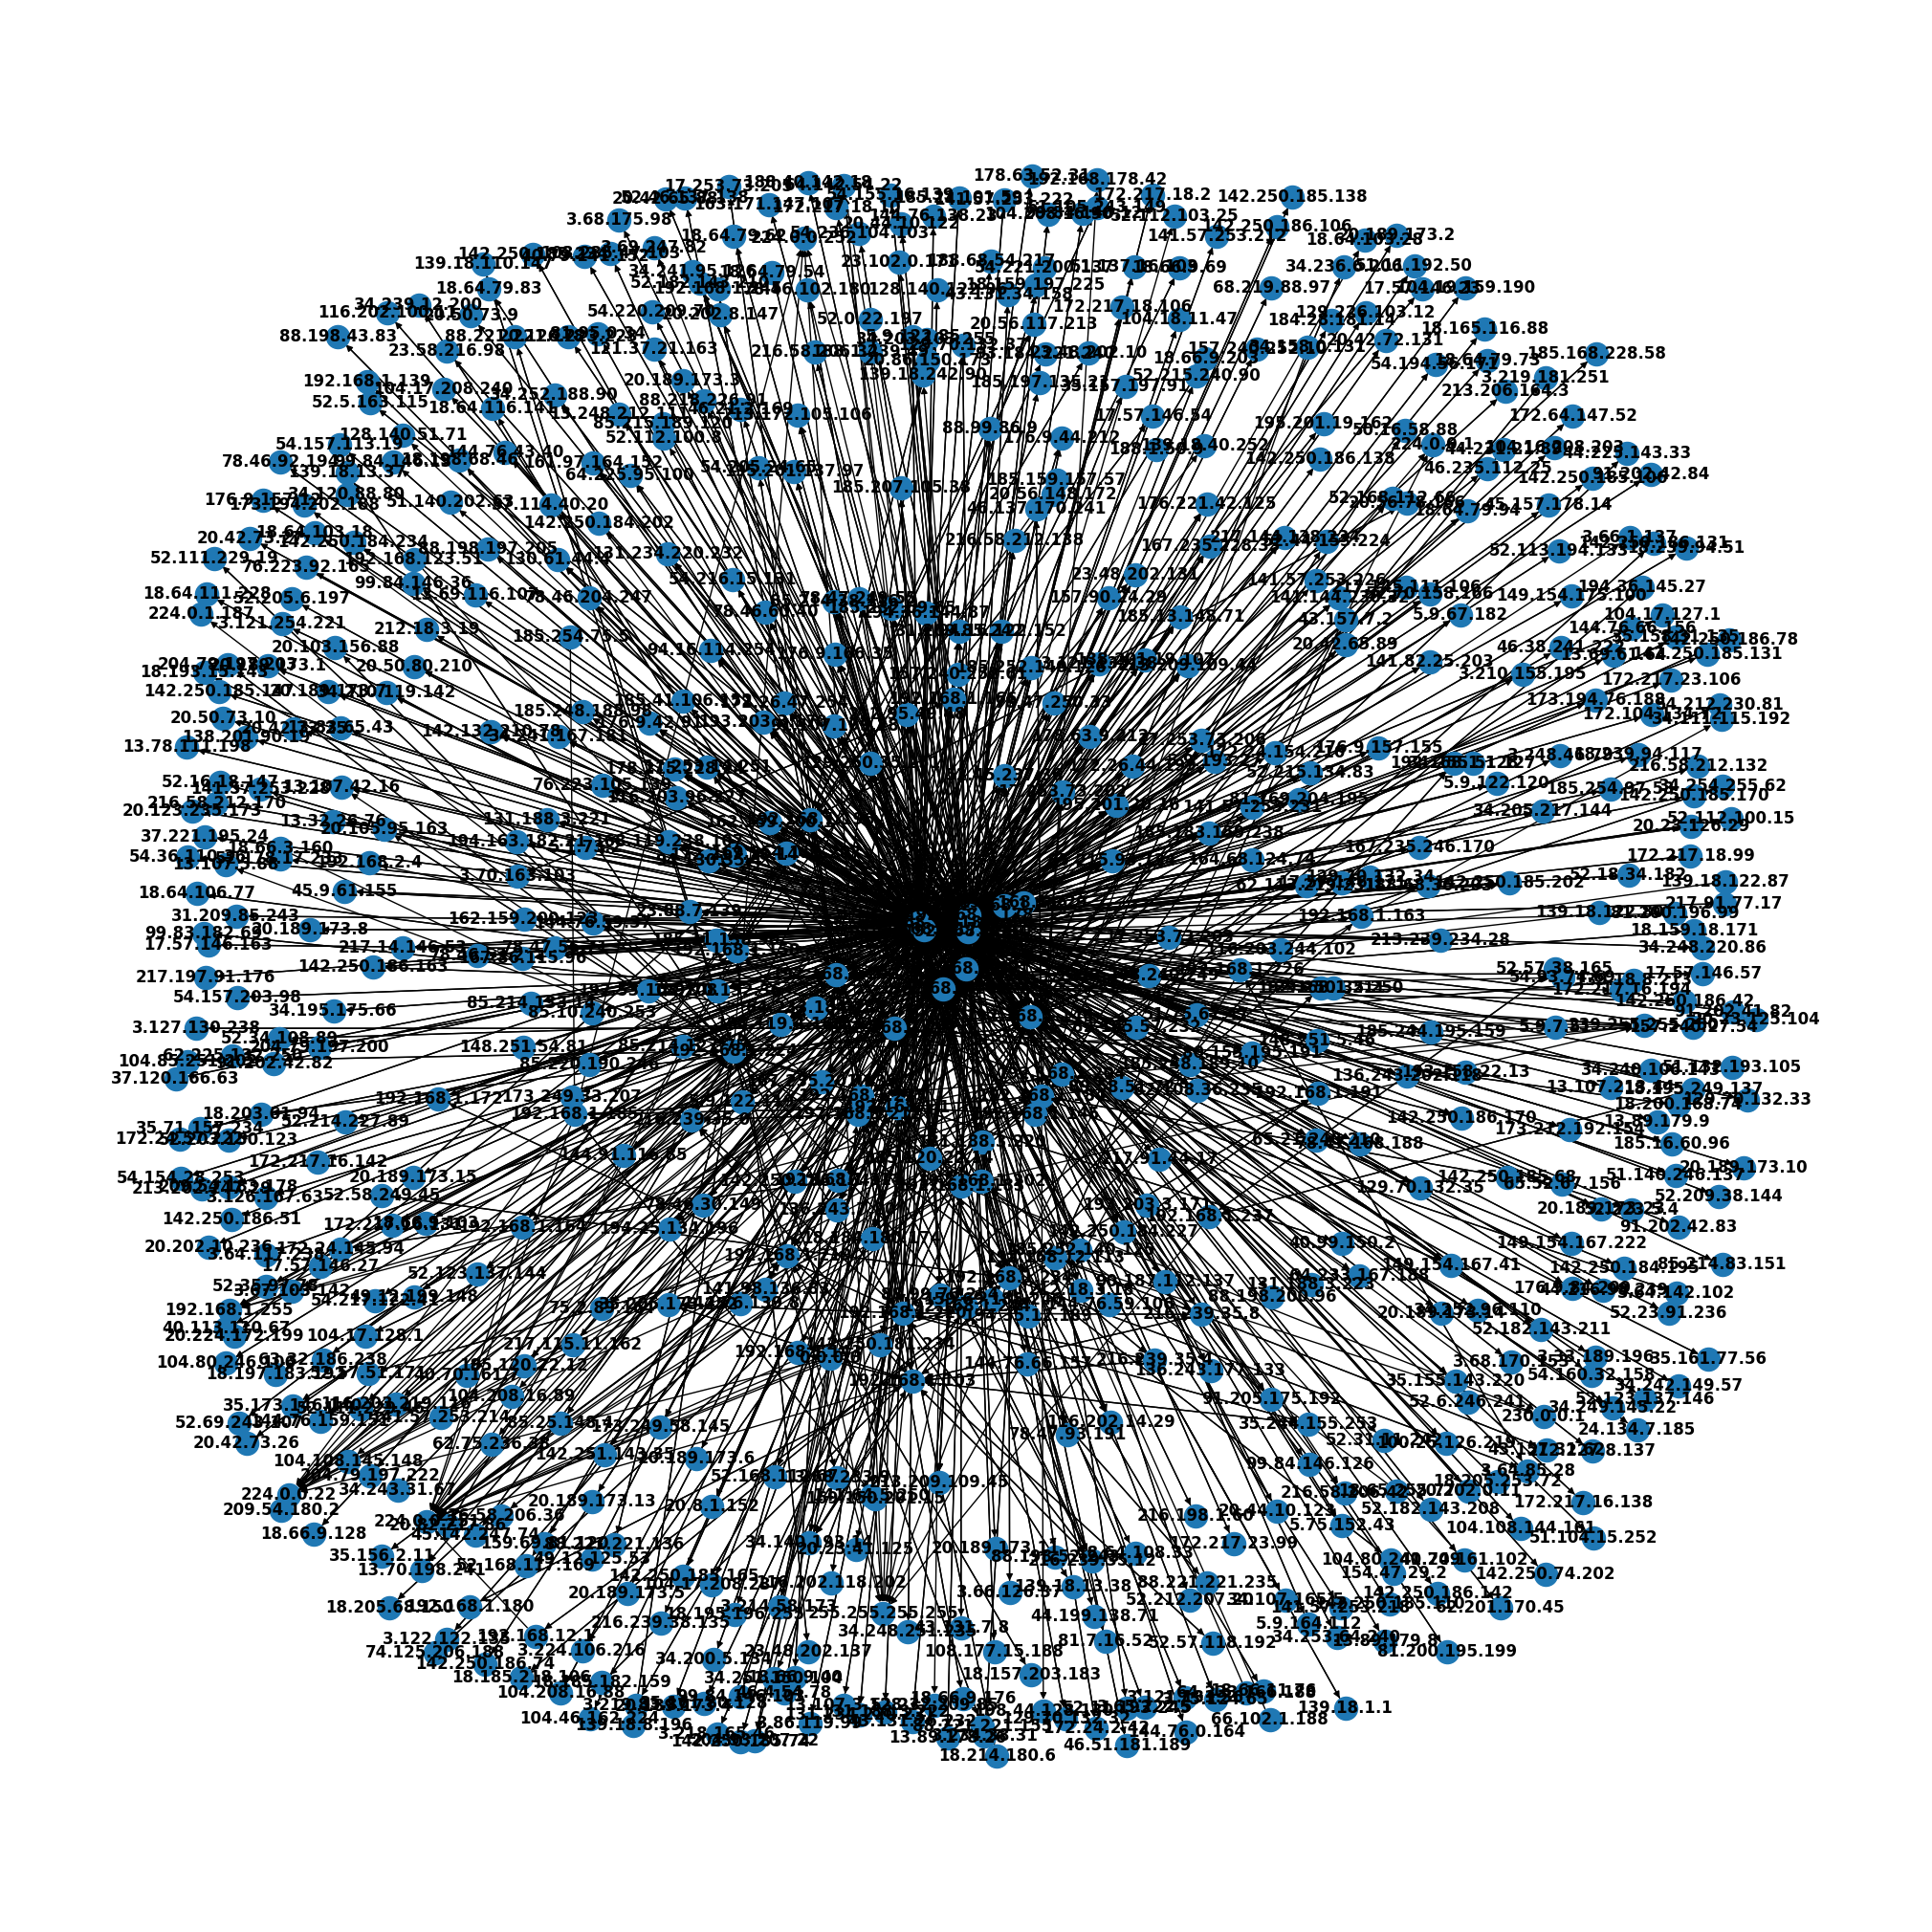

In [24]:
g = state
# set figure size
plt.figure(figsize=(20, 20))
nx.draw(g,
        with_labels=True,
        font_weight='bold',
        # use spring layout
        pos=nx.spring_layout(g, k=0.2, iterations=20, seed=42),
        )

In [25]:
ndoes = list(g.nodes())
edges = list(g.edges())
len(nodes), len(edges)

(660, 1860)

In [27]:
# get connectivity metric for graph
connectivity = nx.edge_connectivity(g)
connectivity

0

In [7]:
# load datasets
datasets_path = os.path.join(devices_root, "datasets.pickle")
with open(datasets_path, "rb") as f:
    datasets = pickle.load(f)

In [8]:
full_dataset = pd.concat(datasets)
full_dataset = full_dataset.fillna(0)

# fill non-existing columns in each dataset with 0 
for dataset in datasets:
    non_existing_columns = [x for x in full_dataset.columns if x not in dataset.columns]
    for column in non_existing_columns:
        dataset[column] = 0

datasets = [dataset for dataset in datasets if len(dataset) > 0]

# make sure columns are sorted the same way in all datasets
datasets = [dataset[full_dataset.columns] for dataset in datasets]

full_dataset

/tmp/ipykernel_19162/2122174075.py:1: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  full_dataset = pd.concat(datasets)


diff_to_last_incoming  new_incoming_at_second  \
0                           0                       1   
2                           2                       0   
20                         18                       0   
33                         13                       0   
40                         13                       0   
...                       ...                     ...   
262108                      0                       1   
262128                      0                       1   
262293                    185                       0   
262442                    149                       0   
262497                    149                       0   

        total_incoming_at_second  total_packet_count_in  total_bytes_in  \
0                              1                   5379          534681   
2                              1                   5379          534681   
20                             1                   5379          534681   
33                             1                   5379          534681   
40                             1                   5379          534681   
...                          ...                    ...             ...   
262108                         1                      5             376   
262128                         1                      5             376   
262293                         1                      5             376   
262442                         1                      5             376   
262497                         1                      5             376   

        src_ports_in  dst_ports_in  packets_per_second_in  \
0                  1             1                      1   
2                  1             1                      4   
20                 1             1                      1   
33                 1             1                      2   
40                 1             1                      2   
...              ...           ...                    ...   
262108             1             1                      2   
262128             1             1                      2   
262293             1             1                      1   
262442             1             1                      2   
262497             1             1                      2   

        bytes_per_second_in  max_tcp_segment_size_in  ...  dst_ports_out  \
0                        66                        0  ...              1   
2                       343                        0  ...              1   
20                       66                        0  ...              1   
33                      169                        0  ...              1   
40                      169                        0  ...              1   
...                     ...                      ...  ...            ...   
262108                  161                        0  ...              1   
262128                  161                        0  ...              1   
262293                   54                        0  ...              1   
262442                  161                        0  ...              1   
262497                  161                        0  ...              1   

        packets_per_second_out  bytes_per_second_out  \
0                            1                    66   
2                            2                   218   
20                           1                    66   
33                           1                   105   
40                           1                    66   
...                        ...                   ...   
262108                       2                   161   
262128                       1                   267   
262293                       2                   161   
262442                       1                   107   
262497                       1                   267   

        max_tcp_segment_size_out  max_tcp_header_length_out  \
0                              0        

In [16]:
full_dataset[full_dataset["attack_at_second_in"] == True]

diff_to_last_incoming  new_incoming_at_second  \
703994                     15                       0   
698995                     10                       0   
24251                      20                       0   
698995                    642                       0   
699025                    642                       0   
...                       ...                     ...   
21362                     269                       0   
22017                     615                       0   
23312                     615                       0   
20654                     106                       0   
20656                       2                       0   

        total_incoming_at_second  total_packet_count_in  total_bytes_in  \
703994                         1                  11969          933475   
698995                         4                   1486          403427   
24251                          0                    787           86806   
698995                         2                    148            9448   
699025                         2                    148            9448   
...                          ...                    ...             ...   
21362                          1                    698           38261   
22017                          1                    698           38261   
23312                          1                    698           38261   
20654                          1                    345           21169   
20656                          1                    345           21169   

        src_ports_in  dst_ports_in  packets_per_second_in  \
703994             2             1                      2   
698995           113             1                      1   
24251              2             1                      2   
698995             3            21                      2   
699025             3            21                      2   
...              ...           ...                    ...   
21362            206           653                      3   
22017            206           653                      1   
23312            206           653                      1   
20654              2           207                     10   
20656              2           207                      1   

        bytes_per_second_in  max_tcp_segment_size_in  ...  dst_ports_out  \
703994                  177                        0  ...              4   
698995                  264                     1440  ...            113   
24251                   169                        0  ...              2   
698995                  112                     1440  ...              3   
699025                  112                     1440  ...              3   
...                     ...                      ...  ...            ...   
21362                   683                     1460  ...            207   
22017                    54                     1460  ...            207   
23312                    54                     1460  ...            207   
20654                   544                     1460  ...              2   
20656                    58                     1460  ...              2   

        packets_per_second_out  bytes_per_second_out  \
703994                       0                     0   
698995                       1                    54   
24251                        1                   105   
698995                       3                   202   
699025                       1                    66   
...                        ...                   ...   
21362                        4                   216   
22017                        1                    74   
23312                        1                    54   
20654                       10                   913   
20656                       10                   913   

        max_tcp_segment_size_out  max_tcp_header_length_out  \
703994                         0        

In [9]:
def combine_activity_and_attack_states(dataset: pd.DataFrame) -> pd.DataFrame:
    # create new column with 0 for no activity, 1 for incoming activity, 2 for outgoing activity,
    activity_field_name = "activity_state"
    dataset[activity_field_name] = 0
    if "activity_at_second_in" in dataset.columns:
        dataset.loc[dataset["activity_at_second_in"] > 0, activity_field_name] = 1
    if "activity_at_second_out" in dataset.columns:
        dataset.loc[dataset["activity_at_second_out"] > 0, activity_field_name] = 2

    # create new column with 0 for no attack, 1 for incoming attack, 2 for outgoing attack,
    attack_field_name = "attack_state"
    dataset[attack_field_name] = 0
    # if "attack_at_second_in" in dataset.columns:
        # dataset.loc[dataset["attack_at_second_in"] > 1, attack_field_name] = 1
    if "attack_at_second_out" in dataset.columns:
        dataset.loc[dataset["attack_at_second_out"] > 0, attack_field_name] = 1

    return dataset


datasets = [combine_activity_and_attack_states(dataset) for dataset in datasets]
full_dataset = combine_activity_and_attack_states(full_dataset)

In [17]:
full_dataset

diff_to_last_incoming  new_incoming_at_second  \
0                           0                       1   
2                           2                       0   
20                         18                       0   
33                         13                       0   
40                         13                       0   
...                       ...                     ...   
262108                      0                       1   
262128                      0                       1   
262293                    185                       0   
262442                    149                       0   
262497                    149                       0   

        total_incoming_at_second  total_packet_count_in  total_bytes_in  \
0                              1                   5379          534681   
2                              1                   5379          534681   
20                             1                   5379          534681   
33                             1                   5379          534681   
40                             1                   5379          534681   
...                          ...                    ...             ...   
262108                         1                      5             376   
262128                         1                      5             376   
262293                         1                      5             376   
262442                         1                      5             376   
262497                         1                      5             376   

        src_ports_in  dst_ports_in  packets_per_second_in  \
0                  1             1                      1   
2                  1             1                      4   
20                 1             1                      1   
33                 1             1                      2   
40                 1             1                      2   
...              ...           ...                    ...   
262108             1             1                      2   
262128             1             1                      2   
262293             1             1                      1   
262442             1             1                      2   
262497             1             1                      2   

        bytes_per_second_in  max_tcp_segment_size_in  ...  \
0                        66                        0  ...   
2                       343                        0  ...   
20                       66                        0  ...   
33                      169                        0  ...   
40                      169                        0  ...   
...                     ...                      ...  ...   
262108                  161                        0  ...   
262128                  161                        0  ...   
262293                   54                        0  ...   
262442                  161                        0  ...   
262497                  161                        0  ...   

        bytes_per_second_out  max_tcp_segment_size_out  \
0                         66                         0   
2                        218                         0   
20                        66                         0   
33                       105                         0   
40                        66                         0   
...                      ...                       ...   
262108                   161                         0   
262128                   267                         0   
262293                   161                         0   
262442                   107                         0   
262497                   267                         0   

        max_tcp_header_length_out  max_frame_length_out  min_frame_length_out  \
0                              32                    66                    66   
2                              32                   113                   105   
20              

In [18]:
datasets[0]

diff_to_last_incoming  new_incoming_at_second  \
0                          0                       1   
2                          2                       0   
20                        18                       0   
33                        13                       0   
40                        13                       0   
...                      ...                     ...   
42496                      7                       0   
42502                      6                       0   
42522                     20                       0   
42523                      1                       0   
42524                      1                       0   

       total_incoming_at_second  total_packet_count_in  total_bytes_in  \
0                             1                   5379          534681   
2                             1                   5379          534681   
20                            1                   5379          534681   
33                            1                   5379          534681   
40                            1                   5379          534681   
...                         ...                    ...             ...   
42496                         1                   5379          534681   
42502                         1                   5379          534681   
42522                         1                   5379          534681   
42523                         1                   5379          534681   
42524                         1                   5379          534681   

       src_ports_in  dst_ports_in  packets_per_second_in  bytes_per_second_in  \
0                 1             1                      1                   66   
2                 1             1                      4                  343   
20                1             1                      1                   66   
33                1             1                      2                  169   
40                1             1                      2                  169   
...             ...           ...                    ...                  ...   
42496             1             1                      2                  173   
42502             1             1                      1                   66   
42522             1             1                      1                   66   
42523             1             1                      2                  163   
42524             1             1                      2                  132   

       max_tcp_segment_size_in  ...  bytes_per_second_out  \
0                            0  ...                    66   
2                            0  ...                   218   
20                           0  ...                    66   
33                           0  ...                   105   
40                           0  ...                    66   
...                        ...  ...                   ...   
42496                        0  ...                   113   
42502                        0  ...                    66   
42522                        0  ...                    66   
42523                        0  ...                    97   
42524                        0  ...                   132   

       max_tcp_segment_size_out  max_tcp_header_length_out  \
0                             0                         32   
2                             0                         32   
20                            0                         32   
33                            0                         32   
40                            0                         32   
...                         ...                        ...   
42496                         0                         32   
42502                         0                         32   
42522                         0                         32   
42523                         0                         32   
42524                         0                         3

In [10]:
# select features to predict
pred_features = ["activity_state",
                 "attack_state",
                 "activity_at_second_in",
                 "activity_at_second_out",
                 "attack_at_second_in",
                 "attack_at_second_out", ]
identity_features = ["node"]

# select features to scale
input_features = [x for x in full_dataset.columns if x not in pred_features + identity_features]
input_features


['diff_to_last_incoming',
 'new_incoming_at_second',
 'total_incoming_at_second',
 'total_packet_count_in',
 'total_bytes_in',
 'src_ports_in',
 'dst_ports_in',
 'packets_per_second_in',
 'bytes_per_second_in',
 'max_tcp_segment_size_in',
 'max_tcp_header_length_in',
 'max_frame_length_in',
 'min_frame_length_in',
 'diff_to_last_outgoing',
 'new_outgoing_at_second',
 'total_outgoing_at_second',
 'total_packet_count_out',
 'total_bytes_out',
 'src_ports_out',
 'dst_ports_out',
 'packets_per_second_out',
 'bytes_per_second_out',
 'max_tcp_segment_size_out',
 'max_tcp_header_length_out',
 'max_frame_length_out',
 'min_frame_length_out']

In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

#  train scaler on full dataset
scaler.fit(full_dataset[input_features])

# save scaler
scaler_path = os.path.join(devices_root, "layer_3_scaler.pickle")
joblib.dump(scaler, scaler_path)

# transform individual datasets
scaled_datasets = [scaler.transform(dataset[input_features]) for dataset in datasets]

# make arrays 3d for input to model
scaled_datasets_3d = [np.expand_dims(dataset, axis=0) for dataset in scaled_datasets]

# create y values with OHE from activity_state column
column_to_use = "attack_state"
y_values_ohe = list()
for dataset in datasets:
    # create ohe array for 
    current_y = np.zeros((len(dataset), 3))
    current_y[np.arange(len(dataset)), dataset[column_to_use].values] = 1
    # make 3d
    current_y = np.expand_dims(current_y, axis=0)
    y_values_ohe.append(current_y)

y_values = list()
for dataset in datasets:
    y_values.append(dataset[column_to_use].values)

# compute class weights
class_weights = dict()
for i in range(len(full_dataset[column_to_use].unique())):
    class_weights[i] = len(full_dataset) / (np.sum(full_dataset[column_to_use] == i) * 3)

class_weights[1] = class_weights[1]

scaled_datasets[0].shape, y_values_ohe[0].shape, class_weights

((3894, 26), (1, 3894, 3), {0: 0.3333680253049956, 1: 3203.1236559139784})

In [12]:
from sklearn.model_selection import train_test_split

# split into train, test and validation
X_train, X_test, y_train, y_test = train_test_split(scaled_datasets_3d, y_values_ohe, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [13]:
# also create a per row training set
per_row_dataset = full_dataset[input_features]
per_row_y = full_dataset[column_to_use].values

per_row_y_ohe = np.zeros((len(per_row_y), 2))
per_row_y_ohe[np.arange(len(per_row_y)), per_row_y] = 1

per_row_dataset_scaled = scaler.transform(per_row_dataset)

X_train_per_row, X_test_per_row, y_train_per_row, y_test_per_row = train_test_split(per_row_dataset_scaled, per_row_y,
                                                                                    test_size=0.2, random_state=42)
X_train_per_row, X_val_per_row, y_train_per_row, y_val_per_row = train_test_split(X_train_per_row, y_train_per_row,
                                                                                  test_size=0.2, random_state=42)

X_train_per_row_ohe, X_test_per_row_ohe, y_train_per_row_ohe, y_test_per_row_ohe = train_test_split(
    per_row_dataset_scaled, per_row_y_ohe,
    test_size=0.2, random_state=42)
X_train_per_row_ohe, X_val_per_row_ohe, y_train_per_row_ohe, y_val_per_row_ohe = train_test_split(X_train_per_row_ohe,
                                                                                                  y_train_per_row_ohe,
                                                                                                  test_size=0.2,
                                                                                                  random_state=42)

X_train_per_row.shape, X_val_per_row.shape, X_test_per_row.shape, y_train_per_row.shape, y_val_per_row.shape, y_test_per_row.shape

((381299, 26), (95325, 26), (119157, 26), (381299,), (95325,), (119157,))

In [14]:
np.unique(y_train_per_row, return_counts=True)

(array([0, 1]), array([381261,     38]))

In [15]:
# use random forest
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=200, 
                                class_weight=class_weights, 
                                random_state=42)
rf_clf.fit(X_train_per_row, y_train_per_row)

# get precision and recall
from sklearn.metrics import precision_score, recall_score, confusion_matrix

y_pred = rf_clf.predict(X_test_per_row)

precision = precision_score(y_test_per_row, y_pred, average="weighted")
recall = recall_score(y_test_per_row, y_pred, average="weighted")

# save model
model_path = os.path.join(devices_root, "outgoing_attack_clf.pickle")
joblib.dump(rf_clf, model_path)

print(confusion_matrix(y_test_per_row, y_pred))

precision, recall

[[119127     15]
 [    12      3]]


(0.9997943863795827, 0.9997734081925527)

In [12]:
np.unique(y_test_per_row, return_counts=True)

(array([0, 1]), array([119138,     19]))

In [59]:
# train imbalanced random forest
from imblearn.ensemble import BalancedRandomForestClassifier

brf_clf = BalancedRandomForestClassifier(n_estimators=100, class_weight=class_weights)
brf_clf.fit(X_train_per_row, y_train_per_row)

y_pred = brf_clf.predict(X_test_per_row)

precision = precision_score(y_test_per_row, y_pred, average="weighted")
recall = recall_score(y_test_per_row, y_pred, average="weighted")

print(confusion_matrix(y_test_per_row, y_pred))

precision, recall

/home/alex/projects/it-security-praktikum/venv/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/home/alex/projects/it-security-praktikum/venv/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/home/alex/projects/it-security-praktikum/venv/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:600: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original p

[[114865   4273]
 [     0     19]]


(0.9998412523810775, 0.9641397483991708)

In [15]:
# create simple nn classifier
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, TimeDistributed
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.optimizers import Adam

# os.environ["CUDA_VISIBLE_DEVICES"] = -1
os.environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir=/opt/cuda"
sys.path.append('/opt/cuda/nvvm/libdevice')

# check for gpu availability
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")


2024-02-26 11:29:12.328746: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-26 11:29:12.328800: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-26 11:29:12.363163: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-26 11:29:12.437078: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-26 11:29:13.680916: W tensorflow/compiler/tf2

GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-02-26 11:29:14.631242: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-26 11:29:14.783683: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-26 11:29:14.783866: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [86]:
# nerual net probably not that good, because of the very unbalanced classes

l2_regulation = 0.00
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(8, activation="relu", input_shape=(X_train_per_row.shape[1],),
                          kernel_regularizer=tf.keras.regularizers.l2(l2_regulation)),
    # tf.keras.layers.Dense(16, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(l2_regulation)),
    # tf.keras.layers.Dense(16, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(l2_regulation)),
    # tf.keras.layers.Dense(16, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(l2_regulation)),
    # tf.keras.layers.Dense(16, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(l2_regulation)),
    tf.keras.layers.Dense(2, activation="softmax")
])

# use early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)

model.compile(optimizer=Adam(learning_rate=0.001), loss="categorical_crossentropy",
              metrics=["accuracy", "mse", "mae", Recall(), Precision()])


history = model.fit(X_train_per_row_ohe, y_train_per_row_ohe, epochs=10, batch_size=64,
                    validation_data=(X_val_per_row_ohe, y_val_per_row_ohe),
                    class_weight=class_weights,
                    callbacks=[early_stopping])


Epoch 1/10
5958/5958 [==============================] - 25s 4ms/step - loss: 0.3668 - accuracy: 0.8925 - mse: 0.1854 - mae: 0.3724 - recall_20: 0.8924 - precision_20: 0.8925 - val_loss: 0.5725 - val_accuracy: 0.8347 - val_mse: 0.1864 - val_mae: 0.3666 - val_recall_20: 0.8347 - val_precision_20: 0.8347
Epoch 2/10
5958/5958 [==============================] - 15s 2ms/step - loss: 0.2049 - accuracy: 0.8795 - mse: 0.1287 - mae: 0.2913 - recall_20: 0.8795 - precision_20: 0.8795 - val_loss: 0.2890 - val_accuracy: 0.9318 - val_mse: 0.0760 - val_mae: 0.2157 - val_recall_20: 0.9318 - val_precision_20: 0.9318
Epoch 3/10
5958/5958 [==============================] - 15s 3ms/step - loss: 0.1634 - accuracy: 0.9000 - mse: 0.0848 - mae: 0.2109 - recall_20: 0.9000 - precision_20: 0.9000 - val_loss: 0.3084 - val_accuracy: 0.8959 - val_mse: 0.0829 - val_mae: 0.1971 - val_recall_20: 0.8959 - val_precision_20: 0.8959
Epoch 4/10
5958/5958 [==============================] - 16s 3ms/step - loss: 0.1183 - accur

In [87]:
# evaluate performance
y_pred = model.predict(X_test_per_row_ohe)

3724/3724 [==============================] - 5s 1ms/step


In [88]:
pred_classes = np.argmax(y_pred, axis=1)
y_actual = np.argmax(y_test_per_row_ohe, axis=1)
precision = precision_score(y_actual, pred_classes, average="weighted")
recall = recall_score(y_actual, pred_classes, average="weighted")
print(confusion_matrix(y_actual, pred_classes))

precision, recall

[[113452   5690]
 [     1     14]]


(0.9998656115222501, 0.9522394823636043)

In [92]:
# save model
model_path = os.path.join(devices_root, "outgoing_attack_nn_clf.pickle")
joblib.dump(model, model_path)

['/home/alex/projects/it-security-praktikum/devices/outgoing_attack_nn_clf.pickle']

In [43]:
index = np.where(y_pred > 0.5)[0]
y_pred[index - 1]

array([[0.]], dtype=float32)

In [ ]:
y_pred = brf_clf.predict_proba(X_val_per_row)
#  count rows with attack
confusion_matrix(y_val_per_row, np.argmax(y_pred, axis=1))

In [65]:
# prepare a small dataset with only attack rows
attack_dataset = full_dataset[full_dataset["attack_state"] == 0]
df_input = attack_dataset[input_features]

# transform input
scaled_input = scaler.transform(df_input)

# classify with rf
attack_predictions = rf_clf.predict_proba(scaled_input)
# attack_predictions

print(confusion_matrix(attack_dataset["attack_state"], np.argmax(attack_predictions, axis=1)))
attack_predictions

[[595651     51]
 [     0      0]]


array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [ ]:
# to same with svm
from sklearn.svm import SVC

svm_clf = SVC(class_weight=class_weights)
svm_clf.fit(X_train_per_row, y_train_per_row)

y_pred = svm_clf.predict(X_test_per_row)

precision = precision_score(y_test_per_row, y_pred, average="weighted")
recall = recall_score(y_test_per_row, y_pred, average="weighted")

precision, recall

In [ ]:
# Define the size of your input
num_features = X_train[0].shape[2]
num_output_features = y_train[0].shape[2]

model = Sequential()
model.add(LSTM(units=30, return_sequences=True, input_shape=(None, num_features)))
model.add(Dense(units=16, activation="relu"))
model.add(Dense(units=8, activation="relu"))
model.add(Dense(units=num_output_features, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy', 'mse', 'mae', Recall(), Precision()])
model.build()
model.summary()

In [ ]:
def data_generator(X, y):
    while True:
        indices = np.arange(len(X))
        indices_shuffled = np.random.permutation(indices)
        for i in indices_shuffled:
            yield X[i], y[i]

In [0]:
history = model.fit(data_generator(X_train, y_train),
                    class_weight=class_weights,
                    epochs=10,
                    batch_size=1,
                    steps_per_epoch=len(scaled_datasets_3d),
                    validation_data=data_generator(X_val, y_val),
                    validation_steps=len(X_val))

In [ ]:
# test the model
pred = model.predict(X_test[0])

In [ ]:
y_test[0][0]

In [ ]:
index = 114
pred = model.predict(X_test[index])
argmaxed = np.argmax(pred, axis=2)
plt.plot(argmaxed[0])
plt.plot(np.argmax(y_test[index], axis=2)[0])